# Imports

In [2]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

from fatiando import utils, mesher, inversion
from fatiando.gravmag import talwani

# Inputs

In [3]:
path = 'FromDUG/'
pklFileName = 'D3A_line2'
extn = '.pkl'
inputFile = open(path + pklFileName + extn, 'rb')
horizons = pickle.load(inputFile)
horizons

{'base_is_Base-PostRift_z': [(0.0, 1896.9099000000001),
  (12.538716042717404, 1896.9099000000001),
  (25.077432085434808, 1896.9099000000001),
  (37.616148128152211, 1896.9099000000001),
  (50.146195269407741, 1896.9099000000001),
  (62.679926611399466, 1896.9099000000001),
  (75.218642636063976, 1896.9099000000001),
  (87.757358665887253, 1896.9099000000001),
  (100.2960746989345, 1896.9099000000001),
  (112.83479073413093, 1896.9099000000001),
  (125.36852276360018, 1896.9099000000001),
  (137.89856924535778, 1896.9099000000001),
  (150.43728527166377, 1896.9099000000001),
  (162.976001300495, 1896.9099000000001),
  (175.51471733131032, 1896.9099000000001),
  (188.04844934197749, 1896.9099000000001),
  (200.58716534194173, 1896.9099000000001),
  (213.11721188103985, 1896.9099000000001),
  (225.65592790782867, 1896.9099000000001),
  (238.19464393629443, 1896.9099000000001),
  (250.72837593696624, 1896.9099000000001),
  (263.26709194273781, 1896.9099000000001),
  (275.8058079518687, 1

In [4]:
polys = []
elements = []
for horizon in horizons:
    elements.append(horizon)
    polys.append(horizons[horizon])

In [46]:
# polys2 = [polys['base_is_Waterbottom_z']]
for p in range(len(elements)):
    print(p, '    ', elements[p])

(0, '    ', 'base_is_Top-Basement_z')
(1, '    ', 'base_is_intra_mantle_z')
(2, '    ', 'base_is_OligUC_z')
(3, '    ', 'base_is_Base-PostRift_z')
(4, '    ', 'base_is_base_crust_z')
(5, '    ', 'base_is_Base-SynRift1_z')
(6, '    ', 'base_is_Base-SynRift2_z')
(7, '    ', 'base_is_Waterbottom_z')
(8, '    ', 'base_is_EocUC_z')


In [53]:
polys2 = [polys[0],polys[7]]

In [54]:
# enter densities for each of the elements listed above
# must be done in the same order of the above elements.

# for d3a2
# densities = [{'density':2500.0},
#              {'density':3200.0},
#              {'density':2000.0},
#              {'density':2300.0},
#              {'density':2750.0},
#              {'density':2500.0},
#              {'density':2400.0},
#              {'density':1060.0},
#              {'density':2200.0}]

densities = [{'density':2500.0},
             {'density':2000.0},]

# densities = [{'density':2500.0},
#              {'density':3200.0},
#              {'density':2000.0},
#              {'density':2300.0},
#              {'density':2750.0}]

In [55]:
# pulling out the max and min values of the bounds of the data
allCoords = []
for i in range(len(polys2)):
    for coords in polys[i]:
        allCoords.append(coords)

arr = np.array(allCoords)

Xmin = arr[0,0]
XminDisplay = 0
line_extn = abs(Xmin - XminDisplay)
Xmax = np.nanmax(arr[:,0])
XmaxDisplay = Xmax - line_extn
Zmin = 0
ZminDisplay = 0
Zmax = np.nanmax(arr[:,1])
ZmaxDisplay = 6200 # to show model to crust depth (allows shallow geometry to be well displayed)

calc_area = [Xmin, Xmax, Zmin, Zmax]
draw_area = [XminDisplay, XmaxDisplay, ZminDisplay, ZmaxDisplay]

In [56]:
# bundling it all up into a single array for computation and plotting
gravModel = [pklFileName, polys2, densities, calc_area, draw_area]

# Defining Gravity Forward Model Calculation

In [57]:
def talwaniCalc(shapes,densities, area):
    """
    Performs the gravity forward model calculation according to
    Talwani et al.'s method as implemented by Fatiando
    
    Takes an array of polygon coordinates (as an array of [X,Y] points)
    and an array of dicts of the same length, each dict having the key
    'density', and the value of the density for the corresponding polygon
    (by index number) in kgm^-3
    """
    PolyDens = []
    for i in range(len(shapes)):
        PolyDens.append(mesher.Polygon(shapes[i],densities[i]))
       
    xp = np.linspace(area[0], area[1], num=100) # define measurement points and compute gravity
    zp = np.zeros_like(xp)
    gz = talwani.gz(xp, zp, PolyDens)
    model = pd.DataFrame({'xp': xp, 'gz':gz})
    return model

# Drawing the Charts

In [60]:
# scenario is an array with a title, array of polygon coordinates, and array of density dicts
def drawAll(scenario):
    plottitle = scenario[0]
    polys = scenario[1]
    densities = scenario[2]
    calc_area = scenario[3]
    draw_area = scenario[4]

    if len(polys) > len(densities):          # dummy checking
        print("One of your polygons is missing a density - check your inputs")
    elif len(polys) < len(densities):
        print("You have more density values than polygons - check your inputs")
        
    NPpolys = []
    for polygon in polys:
        NPpolys.append(Polygon(np.array(polygon),True))
    p = PatchCollection(NPpolys,cmap=matplotlib.cm.jet, alpha = 1) # alpha = transparency
    colours = np.arange(len(polys))
    p.set_array(colours)

    model = talwaniCalc(polys, densities, calc_area)

    plt.subplot(211)
    plt.title(plottitle)
    fig_size = [20,20]
    plt.axis(draw_area)
    plt.gca().invert_yaxis()
    plt.ylabel('Depth (m below sea level)')
    plt.gca().add_collection(p)
    plt.legend(p.get_label())
# # the locations for these labels need to be created manually
#     plt.text(-90000,10000, 'p =' + str(densities[0]['density']))
#     plt.text(0,5000, 'p =' + str(densities[1]['density']))
#     plt.text(100000,5000, 'p =' + str(densities[2]['density']))
#     plt.text(100000,25000, 'p =' + str(densities[3]['density']))

    plt.subplot(212)
    plt.plot(model['xp'], model['gz'], 'r')
    plt.ylabel('Anomaly (mGal)')
    plt.xlim([draw_area[0],draw_area[1]])
    plt.tight_layout()
    plt.rcParams["figure.figsize"] = fig_size
    plt.savefig('wrong.svg')
    plt.show()
    
    
    # drawing the measured grav
def drawGrav(df):
    plt.subplot(211)
    plt.plot(df['dist_along_line'],df['gravity_mgals_grv'],'r-')
    # if the line was taken W-E, the plot flips
    if df.iloc[-1,df.columns.get_loc('long')] < df.iloc[1,df.columns.get_loc('long')]:
        plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.xlabel('Distance Along Line (km)')
    plt.ylabel('Raw Gravity Reading\n(mgals)')
    plt.title('Gravity Readings for line ' + df.iloc[1,df.columns.get_loc('line_name')])
    plt.subplot(212)
    plt.plot(lineReadings['D1B_Line9m']['long'],lineReadings['D1B_Line9m']['lat'],'r-')
    plt.xlabel('Longitude (decimal degrees (WGS84)')
    plt.ylabel('Latitude\n(decimal degrees (WGS84)')
    plt.show()

# Running It

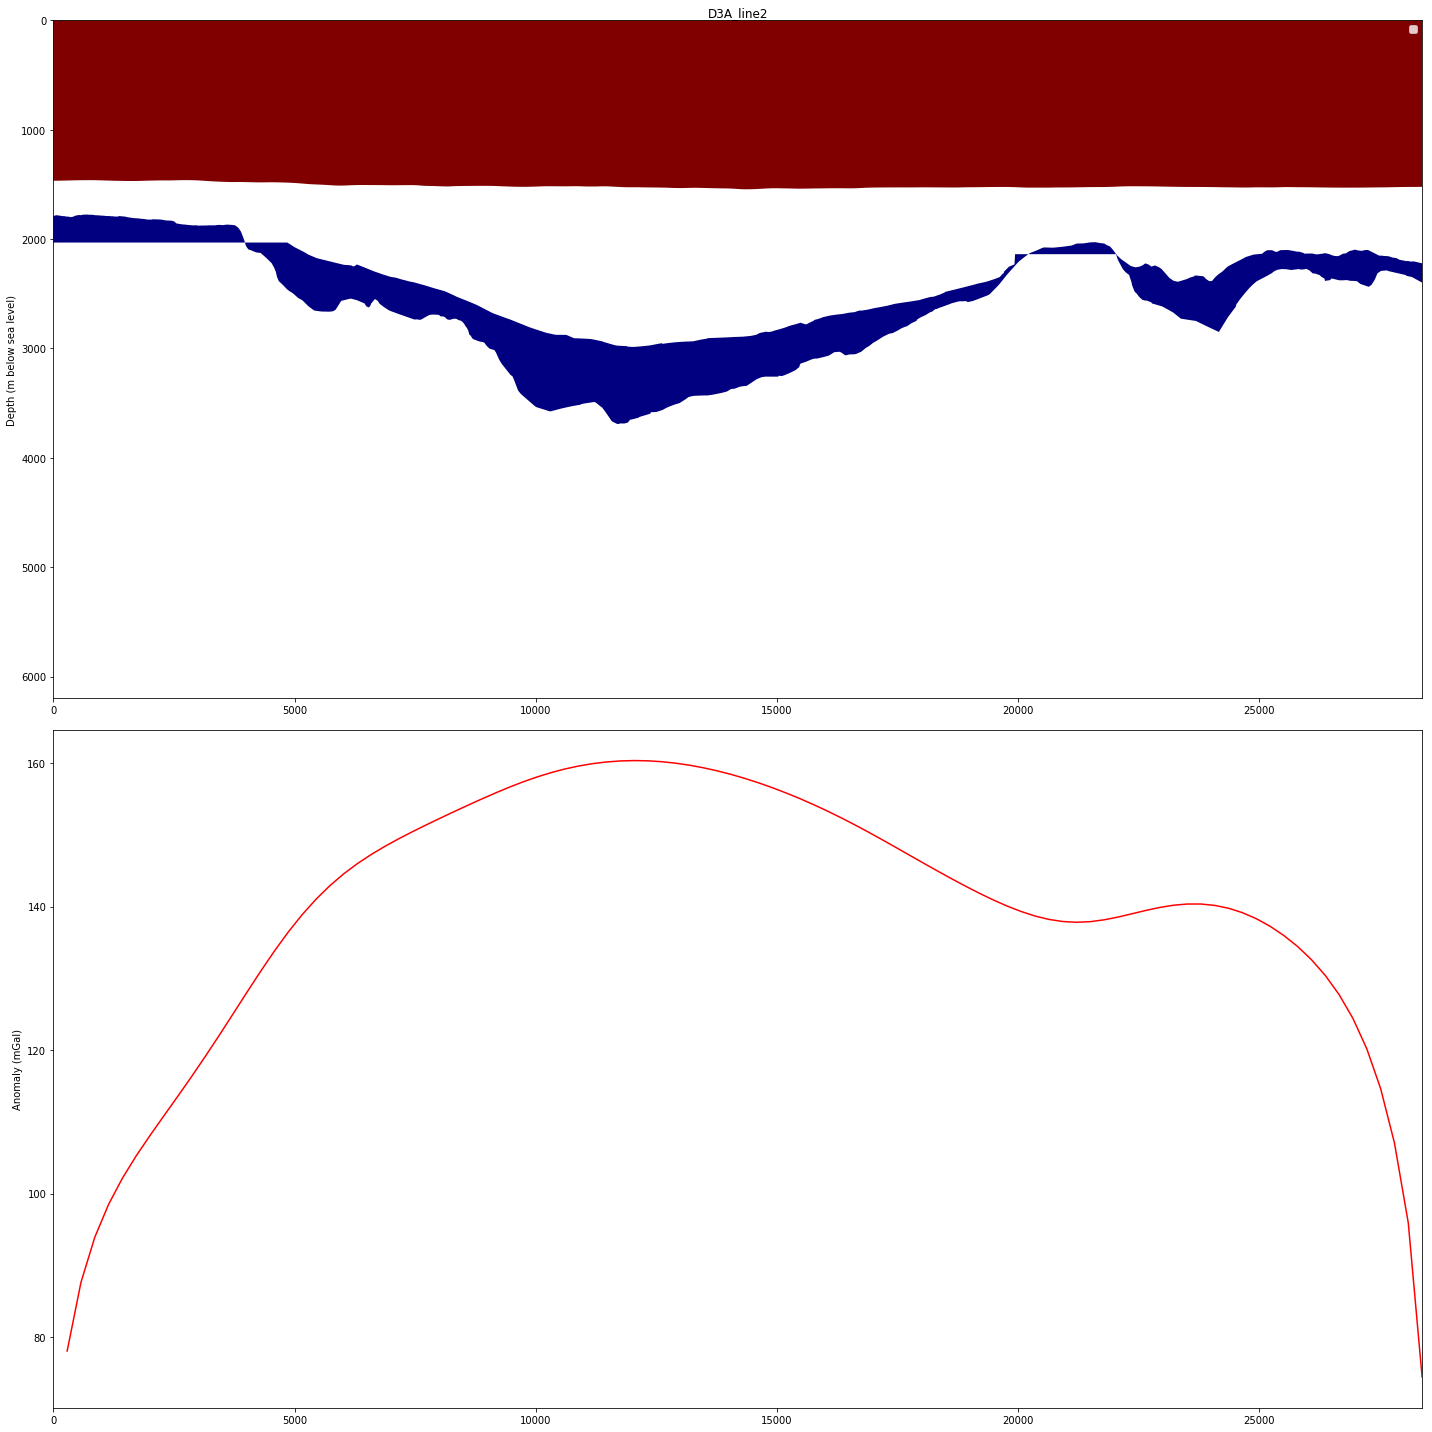

In [61]:
drawAll(gravModel)

C:\Users\u19955\AppData\Local\Continuum\Anaconda3\envs\fatiando\lib\site-packages\mpl_toolkits\basemap\__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


NameError: name 'D3A_Line2_0' is not defined

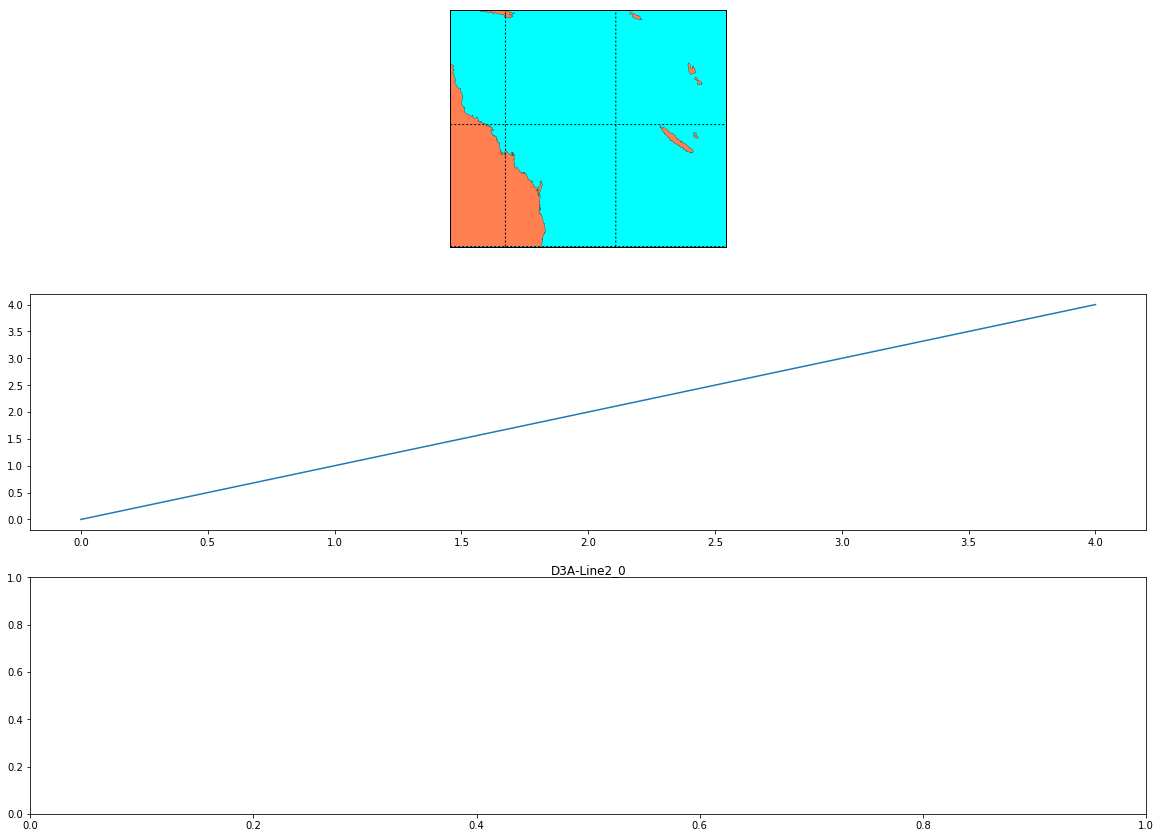

In [13]:
# fig_size = [20,20]

# plt.subplot(411)
# map = Basemap(llcrnrlon=145, llcrnrlat=-30,
#               urcrnrlon=170, urcrnrlat=-10,
#               projection='merc',
#               resolution='l')
# map.drawcoastlines(linewidth=0.25)
# map.drawcountries(linewidth=0.25)
# map.fillcontinents(color='coral',lake_color='aqua')
# map.drawmapboundary(fill_color='aqua')
# map.drawmeridians(np.arange(0,360,10))
# map.drawparallels(np.arange(-90,90,10))
# # map.plot(D3A_Line2_0['long'], D3A_Line2_0['lat'], 'r-', latlong=True)

# plt.subplot(412)
# # plot the polygons (ie crustal model)
# plt.plot(range(5))

# plt.subplot(413)
# # plot the actaul gravity readings
# plt.title('D3A-Line2_0')
# plt.plot(D3A_Line2_0['dist_along_line'], D3A_Line2_0['gravity_mgals_grv'], 'r-')
# plt.xlabel('Distance Along Line (km)')
# plt.ylabel('Gravity Reading (mgals)')

# plt.subplot(414)
# # plot the modelled gravity response
# plt.plot(range(5))

# plt.tight_layout()
# plt.rcParams["figure.figsize"] = fig_size
# plt.show()